In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,6)
from datetime import datetime
from datetime import timedelta
from functools import reduce

from darts import TimeSeries
from darts.models import (
    NaiveSeasonal,
    LinearRegressionModel,
    Prophet,
    NBEATSModel
)

from darts.metrics import mape, mase
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis, plot_hist

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel


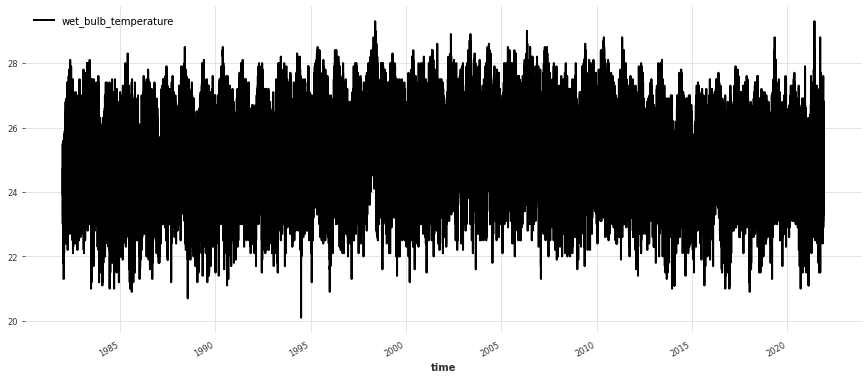

In [3]:
df = pd.read_csv("./data/wet-bulb-temperature-hourly.csv")
dt = [datetime.strptime(df.iloc[n,0], "%Y-%m-%d")+timedelta(hours=int(df.iloc[n,1])-1) for n in range(df.shape[0])]
df.index = dt
df.drop(["wbt_date","wbt_time"],axis=1,inplace=True)
series = TimeSeries.from_dataframe(df)
series.plot()

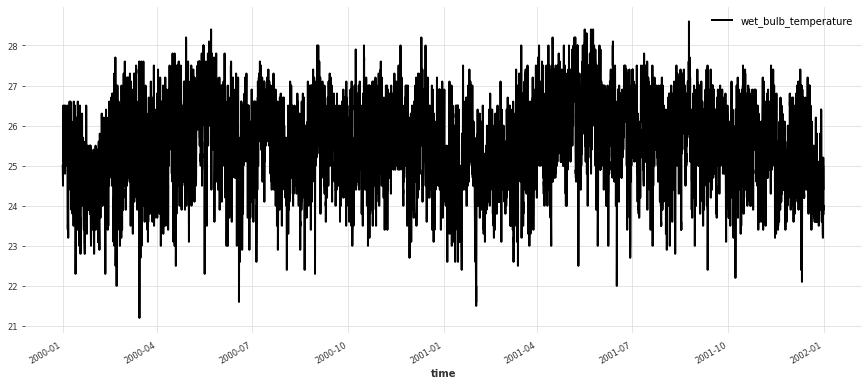

In [4]:
_,series = series.split_before(pd.Timestamp('20000101'))
series,_ = series.split_before(pd.Timestamp('20020101'))
series.plot()

In [5]:
train, val = series.split_before(pd.Timestamp('20010601'))

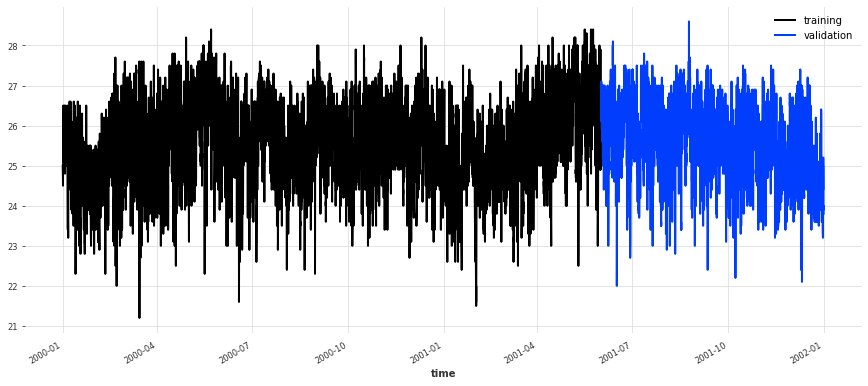

In [6]:
train.plot(label='training')
val.plot(label='validation')
plt.legend();

In [19]:
# define models to test
NS = NaiveSeasonal(K=24)
LR = LinearRegressionModel(lags=24)
PT = Prophet()

NBEATS = NBEATSModel(
    input_chunk_length=24,
    output_chunk_length=24,
    generic_architecture=True,
    num_stacks=2,
    num_blocks=1,
    num_layers=4,
    layer_widths=64,
    n_epochs=20,
    nr_epochs_val_period=1,
    batch_size=16,
    model_name='nbeats_run'
)

RNN = RNNModel(
    model='LSTM',
    hidden_dim=16,
    dropout=0,
    batch_size=16,
    n_epochs=30,
    optimizer_kwargs={'lr': 1e-3},
    model_name='Temp_RNN',
    log_tensorboard=True,
    random_state=16,
    training_length=48,
    input_chunk_length=24,
    force_reset=True,
    save_checkpoints=True
)

models = {"Naive": NS, "Linear": LR, "Prophet": PT, "NBEATS": NBEATS, "RNN": RNN}

In [20]:
# choose models to test
tests = ["Naive", "RNN"]
forecasts = {}
trained_models = {}
for test in tests:
    model = models[test]
    
    if test == "RNN":
        transformer = Scaler()
        train_transformed = transformer.fit_transform(train)
        val_transformed = transformer.transform(val)
        series_transformed = transformer.transform(series)
        
        model.fit(train_transformed, val_series=val_transformed, verbose=True)
        forecast = model.predict(len(val))
        forecast = transformer.inverse_transform(forecast)
        
        trained_models[test] = (transformer, model)
    else:
        model.fit(train)
        forecast = model.predict(len(val))
        trained_models[test] = model
    
    print('model {} obtains MAPE: {:.2f}%'.format(model, mape(val, forecast)))
    forecasts[test] = forecast


model Naive seasonal model, with K=24 obtains MAPE: 3.99%


  0%|          | 0/30 [00:00<?, ?it/s]

model <darts.models.forecasting.rnn_model.RNNModel object at 0x000002542D8E9688> obtains MAPE: 4.28%


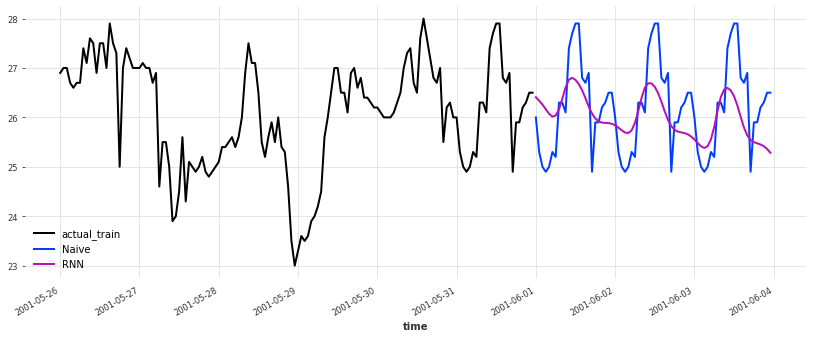

In [24]:
# plot
days_before = 6
days_after = 3

plt.figure(figsize=(14,5))
train[-24*days_before:].plot(label='actual_train')
# val[:24*days_after].plot(label='actual_validation')

for test in tests:
    forecasts[test][:24*days_after].plot(label=test)

plt.legend();

## Backtesting: simulate historical forecasting

In [26]:
bk_test_model = RNN

average_error = bk_test_model.backtest(series_transformed, start=pd.Timestamp('20010101'), forecast_horizon=3, verbose=True, retrain=False)
print("Average error (MAPE) over all historical forecasts: {}".format(average_error))

# raw_errors = bk_test_model.backtest(series, start=pd.Timestamp('20010101'), forecast_horizon=3, reduction=None, verbose=True, retrain=False)
# plot_hist(raw_errors, bins=np.arange(0, max(raw_errors), 1), title='Individual backtest error scores (histogram)')

# historical_fcast = bk_test_model.historical_forecasts(series, start=pd.Timestamp('20010101'), forecast_horizon=3, verbose=True, retrain=False)

  0%|          | 0/8758 [00:00<?, ?it/s]

Average error (MAPE) over all historical forecasts: 10.418484543118003


MAPE: 9.31%


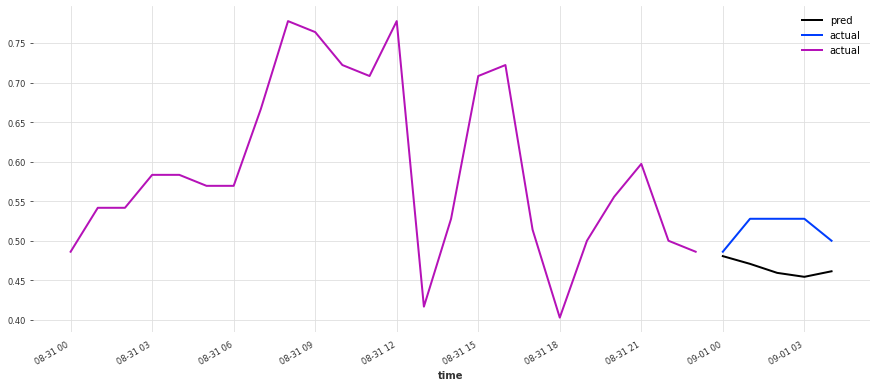

In [31]:
series_test = TimeSeries.from_dataframe(df)
_,series_test = series_test.split_before(pd.Timestamp('19990101'))
series_test,_ = series_test.split_before(pd.Timestamp('20000101'))

series_test_trans = transformer.transform(series_test)
train_test, val_test = series_test_trans.split_before(pd.Timestamp('19990901'))
forecast = bk_test_model.predict(series=train_test, n=5)

forecast.plot(label="pred")
val_test[:5].plot(label="actual")
train_test[-24:].plot(label="actual")
plt.legend();

print('MAPE: {:.2f}%'.format(mape(val_test, forecast)))
